## 1. 数据准备
数据是从[kaggle](https://www.kaggle.com/c/titanic/data)上下载，一共有3个文件
```
├── gender_submission.csv    # 提交示例
├── test.csv     # 测试数据
└── train.csv    # 训练数据
```

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
%matplotlib inline  

读取文件，看看文件格式

In [4]:
train = pd.read_csv('train.csv')
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,NaN,S


表格中各列代表的含义：
+ PassengerID： 乘客ID
+ Survived： 是否存活
+ Pclass：船票类别
+ Name：姓名
+ Sex：性别
+ Age：年龄 
+ SibSp：有无兄弟姐妹和配偶在船上（人数）
+ Parch：有无父母和子女在船上
+ Ticket：票码
+ Fare：票价
+ Cabin：船舱
+ Embarked：出发港

如果要做预测的话，那么我们可以去年PassengerID，Name这直观看起来没有关系的因素。不过这里我觉得Pclass，TIcket，Fare，Cabin，Embarked，SibSp，Parch这几个因素不是很确定，需要下面对数据进行一番探索。

## 2. 数据探索
这里数据探索我们分别对上面有疑问的几个因素进行可视经展示一下，进行简单的探索。

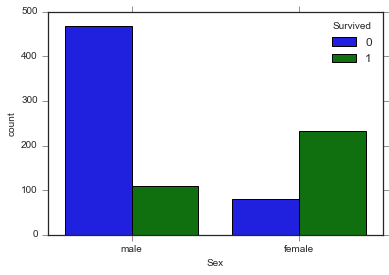

In [51]:
sn.set_style('ticks')
sn.countplot(x='Sex',hue='Survived',data=train)

In [46]:
sn.barplot(x='Fare', y='Survived', data='train')

AttributeError: 'str' object has no attribute 'get'